# Train GAN

- Define and compile discriminator network
- Define and compile generator network
- Combine into GAN and train
- Save images, logs, model artefact

## SETUP

In [1]:
### Environment: conda_gan-tutorial

# Extensions & config
%load_ext autoreload
%autoreload 1

# General package imports
import os, sys
from warnings import warn
from multiprocessing import cpu_count
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

# src imports
src_dir = os.path.join(os.getcwd(), "../src")
sys.path.append(src_dir)
%aimport utils, model

In [2]:
### Variables

prepped_data_file = "../data/celeba_dataset/img_align_celeba.npz" # produced by notebook 1

latent_dim = model.LATENT_DIM_DEF


In [4]:
### Check hardware

gpus = tf.config.experimental.list_logical_devices('GPU')

if len(gpus) > 1:
    print(f"Detected {len(gpus)} GPUs - may need to set up a strategy to actually use these?")
elif len(gpus) == 1:
    print("Running on single GPU - this should happen automatically")
else:
    warn("No GPU detected, training will be slow")

Running on single GPU - this should happen automatically


## DEFINE MODELS
Separate generator and discriminator networks, with combined GAN

In [5]:
# Define stand-alone discriminator network

d_model = model.define_discriminator()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 128)       9728      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       409728    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       409728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)     

In [6]:
# Define the standalone generator model

g_model = model.define_generator(latent_dim)
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3200)              323200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3200)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 20, 20, 128)       0 

In [7]:
# Define the combined generator and discriminator model, for updating the generator

gan_model = model.define_gan(g_model, d_model)
gan_model.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 80, 80, 3)         1381891   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1651841   
Total params: 3,033,732
Trainable params: 1,381,891
Non-trainable params: 1,651,841
_________________________________________________________________


## TRAIN MODEL

In [11]:
# Retrieve set of real images produced by notebook 1

max_images = 10_000

real_img_dataset = utils.retrieve_prep_images(prepped_data_file, scale=True)

if len(real_img_dataset) > max_images:
    real_img_dataset = real_img_dataset[:int(max_images)]

print(f"Loaded {len(real_img_dataset)} images from file {prepped_data_file}, data shape:", real_img_dataset.shape)

Loaded 13 images from file ../data/celeba_dataset/img_align_celeba.npz, data shape: (13, 80, 80, 3)


Data shape: (9, 80, 80, 3)
Label shape: (9, 1)


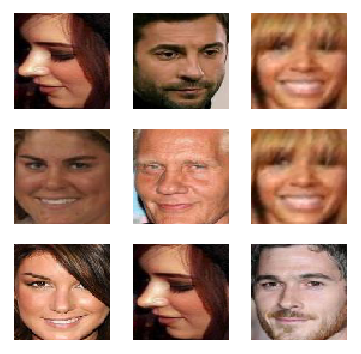

In [12]:
# Example - plot random selection of real images

grid_shape = (3, 3)
n_samples = grid_shape[0] * grid_shape[1]

X_real, y_real = model.generate_real_samples(real_img_dataset, n_samples, seed=42)
print("Data shape:", X_real.shape)
print("Label shape:", y_real.shape)

fig = utils.plot_images(X_real, grid_shape=grid_shape, rescale=True, figsize=(6, 6))
plt.show()

Data shape: (9, 80, 80, 3)
Label shape: (9, 1)


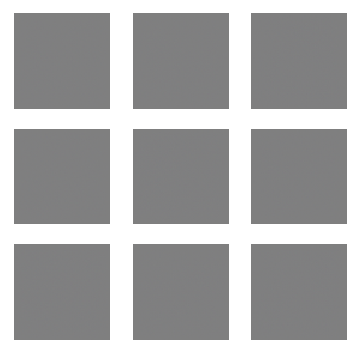

In [13]:
# Example - generate fake images with generator

grid_shape = (3, 3)
n_samples = grid_shape[0] * grid_shape[1]

X_fake, y_fake = model.generate_fake_samples(g_model, n_samples=n_samples, latent_dim=latent_dim, seed=42)
print("Data shape:", X_fake.shape)
print("Label shape:", y_fake.shape)

fig = utils.plot_images(X_fake, grid_shape=grid_shape, rescale=True, figsize=(6, 6))
plt.show()

In [ ]:
# Train model

loss_data, acc_data = model.train(g_model, d_model, gan_model,
                              dataset=real_img_dataset, n_epochs=50, latent_dim=latent_dim)


-------------------------------------------------
Tue Nov 10 13:16:46 2020: BEGIN GAN TRAINING
-------------------------------------------------

Epoch 001, batch 1/3 - loss: D_real=0.099, D_fake=8.896, G=0.070
Epoch 001, batch 2/3 - loss: D_real=0.000, D_fake=1.388, G=0.584
Epoch 001, batch 3/3 - loss: D_real=0.000, D_fake=0.688, G=0.836
Epoch 002, batch 1/3 - loss: D_real=0.578, D_fake=0.567, G=0.964
Epoch 002, batch 2/3 - loss: D_real=0.006, D_fake=0.482, G=1.163
Epoch 002, batch 3/3 - loss: D_real=0.118, D_fake=0.527, G=0.962
Epoch 003, batch 1/3 - loss: D_real=0.560, D_fake=0.562, G=0.933
Epoch 003, batch 2/3 - loss: D_real=0.776, D_fake=1.232, G=0.612
Epoch 003, batch 3/3 - loss: D_real=0.003, D_fake=1.096, G=0.636
Epoch 004, batch 1/3 - loss: D_real=1.065, D_fake=0.849, G=0.716
Epoch 004, batch 2/3 - loss: D_real=0.001, D_fake=0.660, G=0.897
Epoch 004, batch 3/3 - loss: D_real=0.024, D_fake=0.581, G=0.939
Epoch 005, batch 1/3 - loss: D_real=0.560, D_fake=0.592, G=0.837
Epoch 00

Epoch 040, batch 1/3 - loss: D_real=0.280, D_fake=0.244, G=4.803
Epoch 040, batch 2/3 - loss: D_real=0.002, D_fake=0.066, G=4.270
Epoch 040, batch 3/3 - loss: D_real=2.569, D_fake=0.096, G=5.237

Tue Nov 10 13:17:17 2020: Epoch 40 discriminator accuracy: real=100.0%, fake=95.0%
    - sample generated images and model artefacts saved to file

Epoch 041, batch 1/3 - loss: D_real=0.208, D_fake=0.008, G=3.247
Epoch 041, batch 2/3 - loss: D_real=0.000, D_fake=0.395, G=1.147
Epoch 041, batch 3/3 - loss: D_real=0.000, D_fake=0.355, G=3.133
Epoch 042, batch 1/3 - loss: D_real=0.219, D_fake=0.224, G=3.022
Epoch 042, batch 2/3 - loss: D_real=0.000, D_fake=0.271, G=2.348
Epoch 042, batch 3/3 - loss: D_real=0.000, D_fake=0.104, G=2.624
Epoch 043, batch 1/3 - loss: D_real=0.205, D_fake=0.271, G=3.341
Epoch 043, batch 2/3 - loss: D_real=0.000, D_fake=0.234, G=2.397
Epoch 043, batch 3/3 - loss: D_real=0.000, D_fake=0.056, G=3.301
Epoch 044, batch 1/3 - loss: D_real=0.075, D_fake=0.097, G=3.589
Epoch 

---

### Notes on training time/memory requirements:
- On t3a.small:
    - 50 images (16 per batch), 10 epochs: **5 min 11 sec, ~1.3GB RAM**
- On g4dn.2xlarge (prev-gen GPU):
    - 50 images (16 per batch), 10 epochs: **51 sec, ~1.3GB RAM**
    - 500 images (def 128 per batch), 10 epochs: **7 min 58 sec, ~1.6GB RAM**
    - 10k images (def 128 per batch), 50 epochs: **12 hr 33 min 7 sec**
    
- Attempts to get GPU working properly on g4dn.2xlarge, tests with 50 images (16/batch) & 10 epochs:
    - Run blindly after installing tensorflow-gpu and cudatoolkit: **1 min 6 sec**
        - tf.config.list_physical_devices() does NOT show a GPU
    - Run blindly after installing ubuntu cuda drivers: **1 min 9 sec**
        - (but now tf.config.list_physical_devices() does show a GPU)
    - Run after the below commands: **1 min 11 sec**
        - config = tf.compat.v1.ConfigProto(device_count={'GPU': 1, 'CPU': 8})
        - sess = tf.compat.v1.Session(config=config)
        - tf.compat.v1.keras.backend.set_session(sess)
    - Run on new AWS DLAMI instance on conda env copied from built-in tensorflow2_latest_p37: **11 sec**
         - no additional config, session, or setup commands (as above)
         - GPU shown in both tf.config.list_physical_devices() and tf.config.experimental.list_logical_devices()

---

In [ ]:
# Save final models - may be unnecessary as they've been saved throughout

final_fname = utils.name_inter_model_file(epoch='final')

g_model.save(final_fname)
d_model.save(final_fname.replace('generator', 'discriminator'))

## EXPLORE TRAINING RESULTS

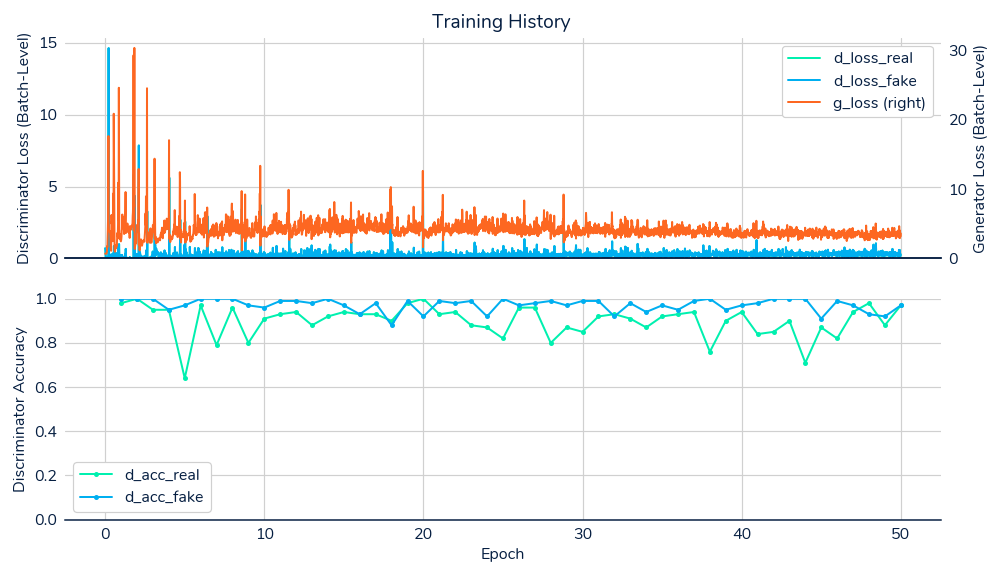

In [18]:
# Plot training history - loss and accuracy

loss_df = pd.read_csv(utils.name_history_file('loss'))
acc_df = pd.read_csv(utils.name_history_file('_acc'))

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14, 8))

loss_df['fract_epoch'] = loss_df.epoch + (loss_df.batch - 1)/loss_df.batch.max()  - 1
loss_df.set_index('fract_epoch').drop(columns=['epoch', 'batch']).plot(ax=axes[0], secondary_y='g_loss')
axes[0].set_ylim(bottom=0)
axes[0].right_ax.set_ylim(bottom=0)
axes[0].set_ylabel("Discriminator Loss (Batch-Level)")
axes[0].right_ax.set_ylabel("Generator Loss (Batch-Level)")
axes[0].grid('x')
axes[0].right_ax.grid(False)

acc_df.set_index('epoch').plot(ax=axes[1], marker='.')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel("Discriminator Accuracy")
axes[1].set_xlabel("Epoch")

fig.tight_layout()
fig.suptitle("Training History")
plt.show()

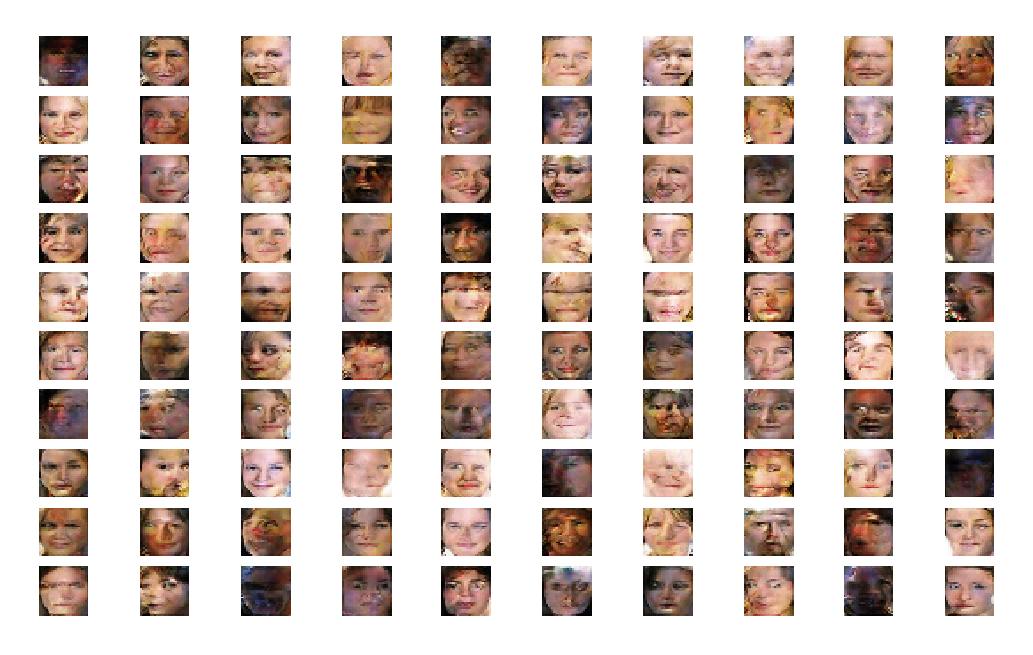

In [15]:
# Look at generated images

utils.disp_intermed_img(epoch=50)

## OLD / BACKUP CELLS

In [14]:
raise RuntimeError('Stop here, dont run old cells')

RuntimeError: Stop here, dont run old cells